<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/tim-ft-densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pydicom -q
#!{sys.executable} -m pip install mpi4py -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

path = '/content/drive/MyDrive/SIADS_699_Capstone/Capstone_Team_Project' #Google Drive path
#path = '/home/ausgear' #Great Lakes
data_path = os.path.join(path, 'data/rsna-pneumonia')
img_path = os.path.join(data_path, 'stage_2_train_images')
obj_path = os.path.join(path, 'python_objects')

In [4]:
import pydicom as dicom
from PIL import Image
import matplotlib.pyplot as plt

def read_img(p_id):
  img_file = os.path.join(img_path, p_id + '.dcm')
  dcm_img = dicom.dcmread(img_file)
  img_arr = dcm_img.pixel_array
  return img_arr

def display_img(img_arr):
  plt.imshow(img_arr, cmap=plt.cm.bone)
  return None

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime

annotations_file = os.path.join(data_path, 'stage_2_train_labels.csv')
label_df = pd.read_csv(annotations_file)
pneum_df = label_df[label_df['Target']==1]
#print(pneum_df.head())

patient_ids = pneum_df['patientId'].unique().tolist()
num_patients = len(patient_ids)

accum_img = np.zeros((1024,1024))

print(num_patients)

for idx, p_id in enumerate(patient_ids):

  img_arr = read_img(p_id)
  accum_img += img_arr
  if idx % 500 == 0:
    print(f'idx: {idx}, percent: {(idx + 1)/len(patient_ids)} time: {datetime.now()}')

6012
idx: 0, percent: 0.00016633399866932801 time: 2022-11-06 15:46:17.303385
idx: 500, percent: 0.08333333333333333 time: 2022-11-06 15:48:29.150356
idx: 1000, percent: 0.16650033266799733 time: 2022-11-06 15:50:30.286328
idx: 1500, percent: 0.24966733200266134 time: 2022-11-06 15:52:31.948528
idx: 2000, percent: 0.3328343313373254 time: 2022-11-06 15:54:37.286108
idx: 2500, percent: 0.41600133067198936 time: 2022-11-06 15:56:51.313675
idx: 3000, percent: 0.49916833000665334 time: 2022-11-06 15:59:06.156986
idx: 3500, percent: 0.5823353293413174 time: 2022-11-06 16:01:18.745543
idx: 4000, percent: 0.6655023286759814 time: 2022-11-06 16:03:34.908108
idx: 4500, percent: 0.7486693280106453 time: 2022-11-06 16:05:50.701492
idx: 5000, percent: 0.8318363273453094 time: 2022-11-06 16:08:06.356692
idx: 5500, percent: 0.9150033266799734 time: 2022-11-06 16:10:19.285831
idx: 6000, percent: 0.9981703260146374 time: 2022-11-06 16:12:24.998044


torch.Size([1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([4])
torch.Size([1, 4])
<class 'PIL.Image.Image'>


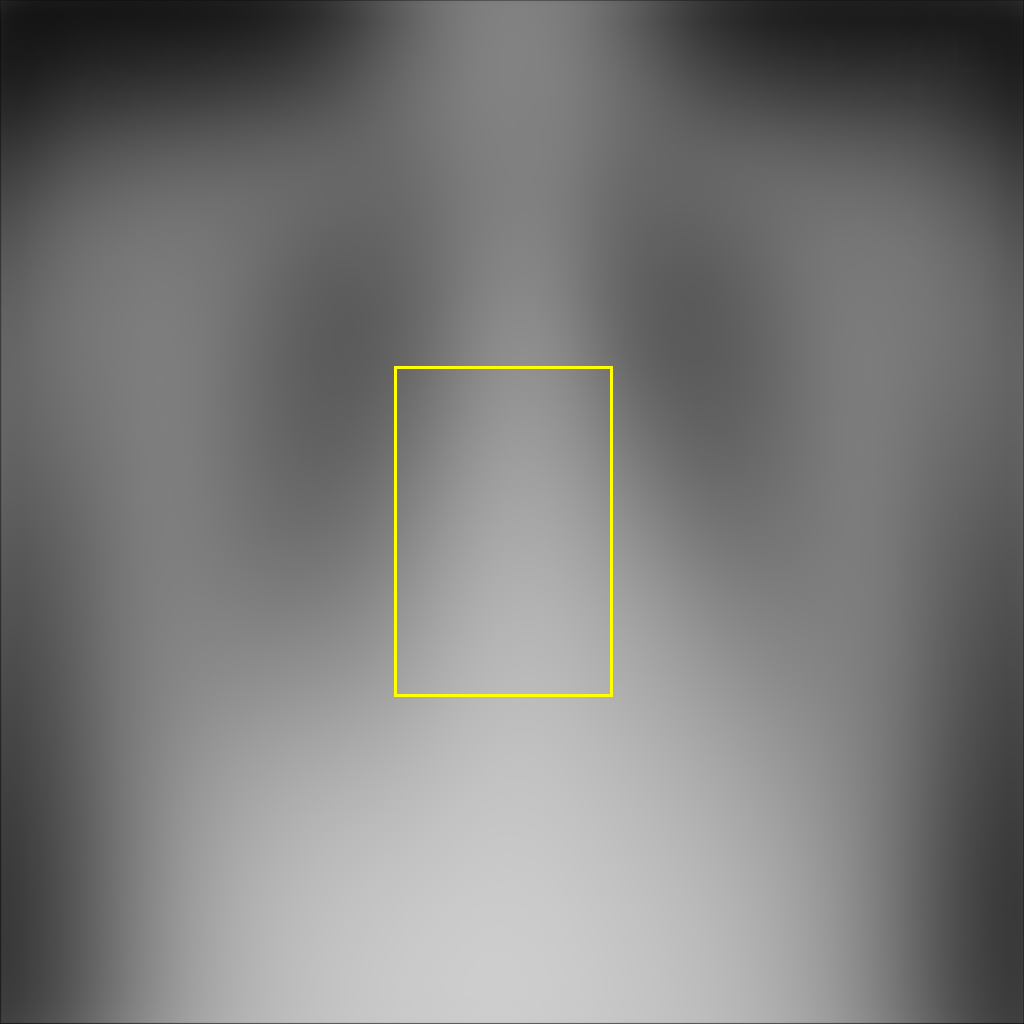

In [8]:
from torchvision.utils import draw_bounding_boxes
import torch
import torchvision

img = np.copy(accum_img)

img = img / num_patients
img = img.astype(np.uint8)
img = torch.from_numpy(img)

print(img.size())
img = img.unsqueeze(0)
print(img.size())

x_mean = pneum_df['x'].mean()
y_mean = pneum_df['y'].mean()
width_mean = pneum_df['width'].mean()
height_mean = pneum_df['height'].mean()

bbox = [x_mean, y_mean, x_mean + width_mean, y_mean + height_mean]
bbox = torch.tensor(bbox, dtype=torch.int)
print(bbox.size())
bbox = bbox.unsqueeze(0)
print(bbox.size())

bb_img = draw_bounding_boxes(img, bbox, width=3, colors=(255,255,0))

bb_img = torchvision.transforms.ToPILImage()(bb_img)
print(type(bb_img))
bb_img

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch
import torchvision
from torch.profiler import profile, record_function, ProfilerActivity

import pydicom as dicom
from PIL import Image

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy